In [ ]:
!wget -nc -O ffhq256-1k-validation.zip 'https://www.dropbox.com/scl/fi/pppstbdsf0em6o0qscruc/ffhq256-1k-validation.zip?rlkey=xl7nwv2nxb6yvsirr3wad77hm'
!unzip -nq ffhq256-1k-validation.zip -d images
!rm ffhq256-1k-validation.zip
!wget -nc -O ffhq_10m.pt 'https://www.dropbox.com/scl/fi/pq72vxzxcbygieq5z4gvf/ffhq_10m.pt?rlkey=5sxdj6r4o9f7b7bbp5fxg2f5r' 


In [1]:
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import torchvision
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from dps.guided_diffusion.unet import create_model
from ddrm.functions.svd_replacement import Inpainting, Deblurring
from ddrm.functions.denoising import efficient_generalized_steps



device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda:0


In [2]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': 'ffhq_10m.pt'}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();

In [3]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  if t.min()<0:
    t = 0.5+0.5*t
  t=t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

def to_pilimg(t):
  if t.min()<0:
    t = 0.5+0.5*t
  t=t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  return(pil_img)

def recover(y_0, H_funcs, sigma=0,flag = 'Denoising'):
    if flag == 'Denoising' or flag == 'Deblurring':
        y = y_0.view(1, 3, 256, 256)
        y+=torch.randn_like(y)*sigma
    elif flag == 'Inpainting':
        kept_indices=H_funcs.kept_indices
        y_0+=torch.randn_like(y_0)*sigma
        y=torch.zeros((1,3,256,256)).to(device)-1

        for i in range(len(kept_indices)):
            idx = kept_indices[i]
            y[0, idx%3, idx//3//256, idx//3%256] = y_0[0, i]
        
    elif flag == 'Colorization':
        y = y_0.view(1, 256, 256)
        y=torch.cat([y, y, y], dim=0).unsqueeze(0)
        y+=torch.randn_like(y)*sigma

    elif 'SuperResolution' in flag:
        factor=int(flag[15:])

        y = y_0.view(1, 3, 256//factor, 256//factor)
        y+=torch.randn_like(y)*sigma
        y_large = torch.zeros((1, 3, 256, 256))
        for i in range(32):  
            for j in range(32):  
                y_large[:, :, i*factor:(i+1)*factor, j*factor:(j+1)*factor] = y[:, :, i:i+1, j:j+1]
        y = y_large
    else : print('flag not recognized')
    return y


## DDPM Class

In [4]:
class DDPM:
  def __init__(self, model=model, time_steps = 1000):
    self.num_diffusion_timesteps = time_steps
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps,
                              dtype=np.float64)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,256,256)


  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (chanels 0 to 2)
    # - learnt variances for the posterior  (chanels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:3,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
      xt = torch.randn(self.imgshape,device=device)  # initialize x_t for t=T
      for i, t in enumerate(self.reversed_time_steps):
        if t > 1:
          z = torch.randn(self.imgshape, device=device)
        else:
          z = torch.zeros(self.imgshape, device=device)

        alpha_t = self.alphas[t]
        alpha_bar_t = self.alphas_cumprod[t]
        sigma_t = np.sqrt(self.betas[t])

        eps = self.get_eps_from_model(xt,t)

        xt = 1/np.sqrt(alpha_t) * (xt -  (1-alpha_t) / np.sqrt(1-alpha_bar_t) * eps ) + sigma_t * z

        xhat = self.predict_xstart_from_eps(xt, eps, t)

        if show_steps and t%100==0:
          print('Iteration :', t)
          pilimg = display_as_pilimg(torch.cat((xt, xhat), dim=3))

    return(xt)

  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):

    # visualization image for the observation y:
    if vis_y==None:
      vis_y = y

    # initialize xt for t=T
    x = torch.randn(self.imgshape,device=device)
    x.requires_grad = True


    for t in tqdm(self.reversed_time_steps[1:]):
      alpha_t = self.alphas[t]
      alpha_bar_t = self.alphas_cumprod[t]
      alpha_bar_tm1 = self.alphas_cumprod_prev[t]

      beta_t = self.betas[t]
      sigma_t = np.sqrt(beta_t)

      z = torch.randn(self.imgshape, device=device)

      xhat = self.predict_xstart_from_eps(x, self.get_eps_from_model(x,t), t)

      x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
      x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
      x_prime += sigma_t*z

      df_term = torch.sum((y-linear_operator(xhat))**2)
      grad = torch.autograd.grad(df_term, x)[0]
      zeta = 0.2 / torch.sqrt(df_term)

      x = x_prime - zeta * grad

      if show_steps and (t)%100==0:
        print('Iteration :', t)
        pilimg = display_as_pilimg(torch.cat((x, xhat, y, x_true), dim=3))

    return(x)

## DDRM Class

In [5]:


class DDRM:
    def __init__(self, model, num_timesteps=1000):
        self.num_timesteps = num_timesteps
        self.reversed_time_steps = np.arange(self.num_timesteps)[::-1]
        beta_start = 0.0001
        beta_end = 0.02
        betas = np.linspace(
            beta_start, beta_end, self.num_timesteps, dtype=np.float64
        )
        betas = self.betas = torch.from_numpy(betas).float().to(device)
        self.num_timesteps = betas.shape[0]

        alphas = 1.0 - betas
        alphas_cumprod = alphas.cumprod(dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0
        )
        self.alphas_cumprod_prev = alphas_cumprod_prev
        self.model = model
        self.imgshape = (1,3,256,256)


    def compute_alpha(self,beta, t):
        beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
        a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
        return a

    def efficient_generalized_steps(self,x, seq, model, b, H_funcs, y_0, sigma_0, etaB, etaA, etaC, cls_fn=None, classes=None):
        with torch.no_grad():
            #setup vectors used in the algorithm
            singulars = H_funcs.singulars()
            Sigma = torch.zeros(x.shape[1]*x.shape[2]*x.shape[3], device=x.device)
            Sigma[:singulars.shape[0]] = singulars
            U_t_y = H_funcs.Ut(y_0)
            Sig_inv_U_t_y = U_t_y / singulars[:U_t_y.shape[-1]]

            #initialize x_T as given in the paper
            largest_alphas = self.compute_alpha(b, (torch.ones(x.size(0)) * seq[-1]).to(x.device).long())
            largest_sigmas = (1 - largest_alphas).sqrt() / largest_alphas.sqrt()
            large_singulars_index = torch.where(singulars * largest_sigmas[0, 0, 0, 0] > sigma_0)
            inv_singulars_and_zero = torch.zeros(x.shape[1] * x.shape[2] * x.shape[3]).to(singulars.device)
            inv_singulars_and_zero[large_singulars_index] = sigma_0 / singulars[large_singulars_index]
            inv_singulars_and_zero = inv_singulars_and_zero.view(1, -1)     

            # implement p(x_T | x_0, y) as given in the paper
            # if eigenvalue is too small, we just treat it as zero (only for init) 
            init_y = torch.zeros(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]).to(x.device)
            init_y[:, large_singulars_index[0]] = U_t_y[:, large_singulars_index[0]] / singulars[large_singulars_index].view(1, -1)
            init_y = init_y.view(*x.size())
            remaining_s = largest_sigmas.view(-1, 1) ** 2 - inv_singulars_and_zero ** 2
            remaining_s = remaining_s.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3]).clamp_min(0.0).sqrt()
            init_y = init_y + remaining_s * x
            init_y = init_y / largest_sigmas
            
            #setup iteration variables
            x = H_funcs.V(init_y.view(x.size(0), -1)).view(*x.size())
            n = x.size(0)
            seq_next = [-1] + list(seq[:-1])
            x0_preds = []
            xs = [x]

            #iterate over the timesteps
            for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
                t = (torch.ones(n) * i).to(x.device)
                next_t = (torch.ones(n) * j).to(x.device)
                at = self.compute_alpha(b, t.long())
                at_next = self.compute_alpha(b, next_t.long())
                xt = xs[-1].to('cuda')
                if cls_fn == None:
                    et = model(xt, t)
                else:
                    et = model(xt, t, classes)
                    et = et[:, :3]
                    et = et - (1 - at).sqrt()[0,0,0,0] * cls_fn(x,t,classes)
                
                if et.size(1) == 6:
                    et = et[:, :3]
                
                x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

                #variational inference conditioned on y
                sigma = (1 - at).sqrt()[0, 0, 0, 0] / at.sqrt()[0, 0, 0, 0]
                sigma_next = (1 - at_next).sqrt()[0, 0, 0, 0] / at_next.sqrt()[0, 0, 0, 0]
                xt_mod = xt / at.sqrt()[0, 0, 0, 0]
                V_t_x = H_funcs.Vt(xt_mod)
                SVt_x = (V_t_x * Sigma)[:, :U_t_y.shape[1]]
                V_t_x0 = H_funcs.Vt(x0_t)
                SVt_x0 = (V_t_x0 * Sigma)[:, :U_t_y.shape[1]]

                falses = torch.zeros(V_t_x0.shape[1] - singulars.shape[0], dtype=torch.bool, device=xt.device)
                cond_before_lite = singulars * sigma_next > sigma_0
                cond_after_lite = singulars * sigma_next < sigma_0
                cond_before = torch.hstack((cond_before_lite, falses))
                cond_after = torch.hstack((cond_after_lite, falses))

                std_nextC = sigma_next * etaC
                sigma_tilde_nextC = torch.sqrt(sigma_next ** 2 - std_nextC ** 2)

                std_nextA = sigma_next * etaA
                sigma_tilde_nextA = torch.sqrt(sigma_next**2 - std_nextA**2)
                
                diff_sigma_t_nextB = torch.sqrt(sigma_next ** 2 - sigma_0 ** 2 / singulars[cond_before_lite] ** 2 * (etaB ** 2))

                #missing pixels
                Vt_xt_mod_next = V_t_x0 + sigma_tilde_nextC * H_funcs.Vt(et) + std_nextC * torch.randn_like(V_t_x0)

                #less noisy than y (after)
                Vt_xt_mod_next[:, cond_after] = \
                    V_t_x0[:, cond_after] + sigma_tilde_nextA * ((U_t_y - SVt_x0) / sigma_0)[:, cond_after_lite] + std_nextA * torch.randn_like(V_t_x0[:, cond_after])
                
                #noisier than y (before)
                Vt_xt_mod_next[:, cond_before] = \
                    (Sig_inv_U_t_y[:, cond_before_lite] * etaB + (1 - etaB) * V_t_x0[:, cond_before] + diff_sigma_t_nextB * torch.randn_like(U_t_y)[:, cond_before_lite])

                #aggregate all 3 cases and give next prediction
                xt_mod_next = H_funcs.V(Vt_xt_mod_next)
                xt_next = (at_next.sqrt()[0, 0, 0, 0] * xt_mod_next).view(*x.shape)

                x0_preds.append(x0_t.to('cpu'))
                xs.append(xt_next.to('cpu'))


        return xs, x0_preds

    def sample_image(self, x, model, H_funcs, y_0, sigma_0, eta, etaB, skip=1, last=True, cls_fn=None, classes=None):
            seq = range(0, self.num_timesteps, skip)
            
            x = self.efficient_generalized_steps(x, seq, model, self.betas, H_funcs, y_0, sigma_0, \
                etaB=etaB, etaA=eta, etaC=eta, cls_fn=cls_fn, classes=classes)
            if last:
                x = x[0][-1]
            return x

## Inpainting without noise

cuda:0
original image 00012.png


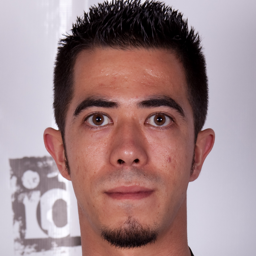

noisy measurement


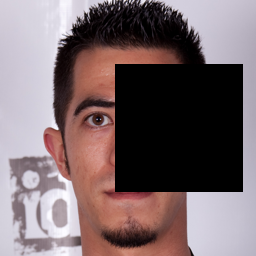

torch.Size([1, 3, 256, 256])


In [28]:
h = 256
w = 256
hcrop, wcrop = h//2, w//2
corner_top, corner_left = h//4, int(0.45*w)
mask = torch.ones((1,3,256, 256), device=device)
mask[:,:,corner_top:corner_top+hcrop,corner_left:corner_left+wcrop] = 0

def linear_operator(x):
  x = x.reshape(1,3,256,256)
  x = x*mask - (1-mask)
  return(x)

idx = 12
x_true_pil = Image.open('images/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true)

sigma_noise = 0

y = linear_operator(x_true.clone()) + sigma_noise * mask * torch.randn_like(x_true)
print("noisy measurement")
display_as_pilimg(y);

print(y.size())


In [21]:
## Create the Inpainting object for DDRM
mask=mask.squeeze()[0].flatten()
missing_r = torch.nonzero(mask == 0).long().reshape(-1)*3
missing_g = missing_r + 1
missing_b = missing_g + 1
missing = torch.cat([missing_r, missing_g, missing_b], dim=0)
H_funcs = Inpainting(3, 256, missing, device)

In [20]:
y_0 = H_funcs.H(x_true) 
y_0.shape

torch.Size([1, 147456])

In [36]:
ddpm = DDPM(model)
x_reconstructed_ddpm = ddpm.posterior_sampling(linear_operator, y, show_steps = False)
ddrm=DDRM(model)
x_reconstructed_ddrm=ddrm.sample_image(x_true, model, H_funcs, y_0, sigma_0 = 0, eta = 1, etaB = 0.85, skip=1, last=True, cls_fn=None, classes=None)

100%|██████████| 999/999 [02:12<00:00,  7.53it/s]
1000it [01:06, 14.95it/s]


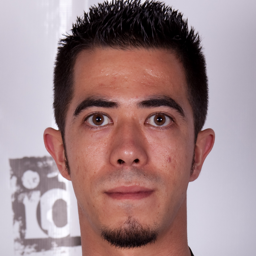

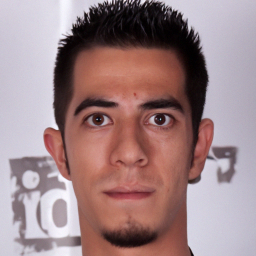

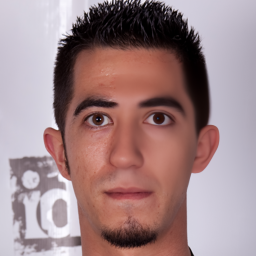

In [37]:
display_as_pilimg(x_true);
display_as_pilimg(x_reconstructed_ddpm);
display_as_pilimg(x_reconstructed_ddrm);


In [38]:
psnr_dps = 10*torch.log10(4/torch.mean((x_true.to('cpu')-x_reconstructed_ddpm.to('cpu'))**2)).item()
psnr_ddrm = 10*torch.log10(4/torch.mean((x_true.to('cpu')-x_reconstructed_ddrm.to('cpu'))**2)).item()
print('PSNR of DDPM:', psnr_dps)
print('PSNR of DDRM:', psnr_ddrm)

PSNR of DDPM: 24.6885347366333
PSNR of DDRM: 26.997814178466797


## Gaussian deblurring

cuda:0
original image 00010.png


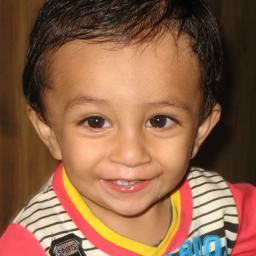

noisy measurement


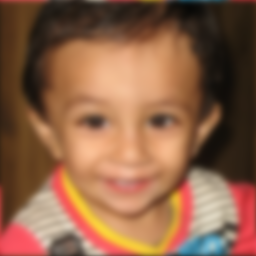

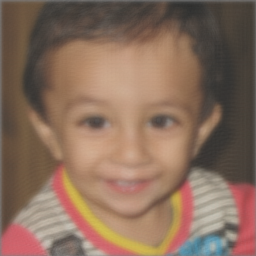

torch.Size([1, 3, 256, 256])


In [6]:
idx = 10
x_true_pil = Image.open('images/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true)

sigma = 10
pdf = lambda x: torch.exp(torch.Tensor([-0.5 * (x/sigma)**2]))
kernel = torch.Tensor([pdf(-2), pdf(-1), pdf(0), pdf(1), pdf(2)]).to(device)
H_funcs_gaussian_blur = Deblurring(kernel / kernel.sum(),3, 256, device)
y_0 = recover(H_funcs_gaussian_blur.H(x_true), H_funcs_gaussian_blur, flag = 'Deblurring')

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - size//2)**2 + (y - size//2)**2) / (2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

# Define the size of the kernel (256x256) and the standard deviation
kernel_size = 256
sigma = 10**0.5

# Generate the Gaussian kernel
gaussian_kernel_256 = torch.tensor(gaussian_kernel(kernel_size, sigma))
gaussian_kernel_256_centered = torch.roll(gaussian_kernel_256, shifts=(kernel_size//2, kernel_size//2), dims=(0, 1))


def linear_operator_blur(x):
  y = fft2(x) * fft2(gaussian_kernel_256_centered.to(device))
  y = ifft2(y).real

  return y



sigma_noise = 0

y = linear_operator_blur(x_true).clamp(-1.,1.)
print("noisy measurement")
display_as_pilimg(y);
display_as_pilimg(y_0);
print(y.size())

In [7]:
# ddpm = DDPM(model)
# x_reconstructed_ddpm = ddpm.posterior_sampling(linear_operator_blur, y, show_steps = False)
ddrm=DDRM(model)
x_reconstructed_ddrm=ddrm.sample_image(x_true, model, H_funcs_gaussian_blur, y_0, sigma_0 = 0, eta = 1, etaB = 0.85, skip=1, last=True, cls_fn=None, classes=None)

9it [00:00, 13.15it/s]

1000it [01:06, 15.15it/s]


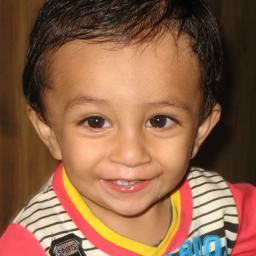

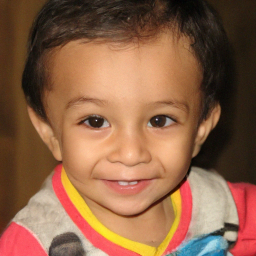

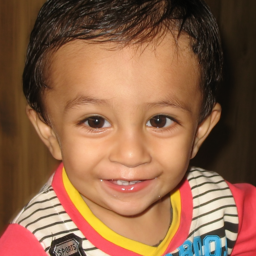

In [8]:
display_as_pilimg(x_true);
display_as_pilimg(x_reconstructed_ddpm);
display_as_pilimg(x_reconstructed_ddrm);


## Skip analysis

In [106]:
y_0 = H_funcs.H(x_true) 

psnrs = []
rmse = []
skips = np.linspace(1, 100, 10).astype(int)
for skip in skips:
    ddrm=DDRM(model)
    x_reconstructed_ddrm=ddrm.sample_image(x_true, model, H_funcs, y_0, sigma_0 = 0, eta = 1, etaB = 0.85, skip=skip, last=True, cls_fn=None, classes=None)
    PSNR = 10*torch.log10(4/torch.mean((x_true.to('cpu')-x_reconstructed_ddrm.to('cpu'))**2)).item()
    RMSE = torch.sqrt(torch.mean((x_true.to('cpu')-x_reconstructed_ddrm.to('cpu'))**2)).item()
    psnrs.append(PSNR)
    rmse.append(RMSE)
    print(f"PSNR at skip={skip} : {PSNR} dB")
    print(f"RMSE at skip={skip} : {RMSE}")
    print('')

1000it [01:06, 15.02it/s]


PSNR at skip=1 : 26.548519134521484 dB
RMSE at skip=1 : 0.0941031202673912



84it [00:05, 14.97it/s]


PSNR at skip=12 : 23.858413696289062 dB
RMSE at skip=12 : 0.12826532125473022



44it [00:02, 14.97it/s]


PSNR at skip=23 : 25.853066444396973 dB
RMSE at skip=23 : 0.10194750875234604



30it [00:02, 14.94it/s]


PSNR at skip=34 : 28.11253070831299 dB
RMSE at skip=34 : 0.07859653979539871



23it [00:01, 14.96it/s]


PSNR at skip=45 : 11.418259143829346 dB
RMSE at skip=45 : 0.5371765494346619



18it [00:01, 14.96it/s]


PSNR at skip=56 : 7.42328405380249 dB
RMSE at skip=56 : 0.8508750796318054



15it [00:01, 14.97it/s]


PSNR at skip=67 : 4.4445183873176575 dB
RMSE at skip=67 : 1.1989582777023315



13it [00:00, 14.96it/s]


PSNR at skip=78 : 2.3114360868930817 dB
RMSE at skip=78 : 1.5327036380767822



12it [00:00, 14.96it/s]


PSNR at skip=89 : -2.4613308906555176 dB
RMSE at skip=89 : 2.655195713043213



10it [00:00, 14.97it/s]

PSNR at skip=100 : 0.4241938889026642 dB
RMSE at skip=100 : 1.904672384262085



0it [00:00, ?it/s]

100it [00:06, 15.51it/s]


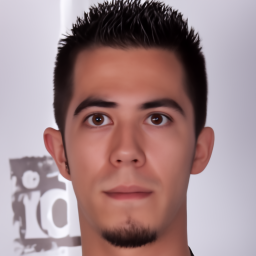

In [127]:
x_reconstructed_ddrm=ddrm.sample_image(x_true, model, H_funcs, y_0, sigma_0 = 0.1, eta = 1, etaB = 0.85, skip=10, last=True, cls_fn=None, classes=None)
display_as_pilimg(x_reconstructed_ddrm);

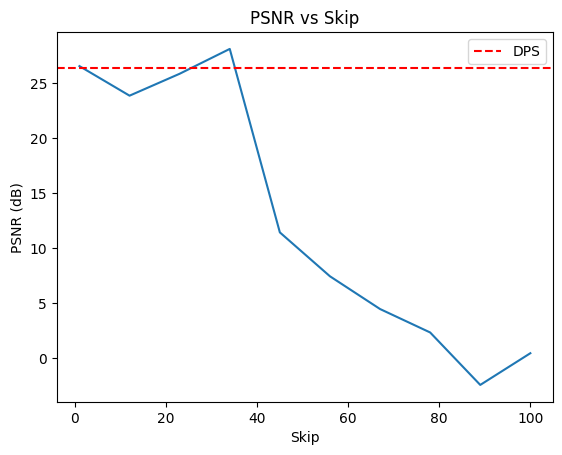

In [111]:
plt.plot(skips, psnrs)
plt.axhline(psnr_dps, color='r', linestyle='--', label='DPS')
plt.xlabel('Skip')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Skip')
plt.legend()
plt.show()

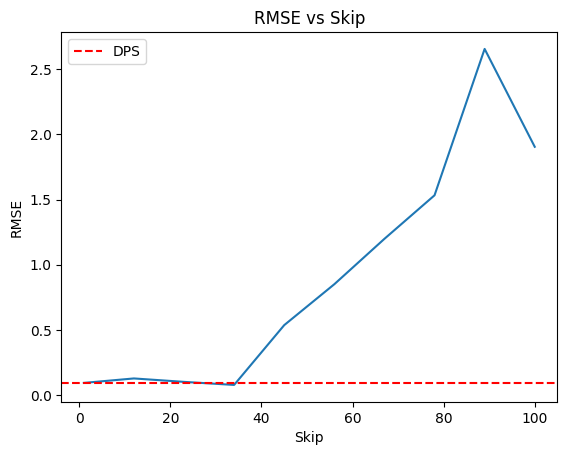

In [112]:
plt.plot(skips, rmse)
plt.axhline(rmse_dps, color='r', linestyle='--', label='DPS')
plt.xlabel('Skip')
plt.ylabel('RMSE')
plt.title('RMSE vs Skip')
plt.legend()
plt.show()        

## Varying noise at constant $\sigma_y$

cuda:0
original image 00045.png


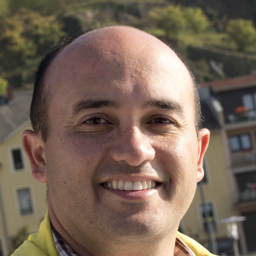

In [9]:
idx = 45
x_true_pil = Image.open('images/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true);

## Create the Inpainting object for DDRM
h = 256
w = 256
hcrop, wcrop = h//2, w//2
corner_top, corner_left = h//4, int(0.45*w)
mask = torch.ones((1,3,256, 256), device=device)
mask[:,:,corner_top:corner_top+hcrop,corner_left:corner_left+wcrop] = 0

mask=mask.squeeze()[0].flatten()
missing_r = torch.nonzero(mask == 0).long().reshape(-1)*3
missing_g = missing_r + 1
missing_b = missing_g + 1
missing = torch.cat([missing_r, missing_g, missing_b], dim=0)
H_funcs = Inpainting(3, 256, missing, device)

In [19]:
sigma_noises = [0, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
sigma_ys = [0, 0.05, 0.1]

NUM_ITER = 10

psnrs_all = []
stds = []
ddrm=DDRM(model)
for sigma_0 in sigma_ys:
    psnrs = np.zeros((NUM_ITER, len(sigma_noises)))
    for it in range(NUM_ITER):
        for idx, sigma_noise in enumerate(sigma_noises):
            y_0 = H_funcs.H(x_true) 
            y_0 += torch.randn_like(y_0)*sigma_noise
            x_rec = ddrm.sample_image(x_true, model, H_funcs, y_0, sigma_0 = sigma_0, eta = 1, etaB = 0.85, skip=20, last=True, cls_fn=None, classes=None)
            psnr = 10*torch.log10(4/torch.mean((x_true.to('cpu')-x_rec.to('cpu'))**2)).item()
            psnrs[it, idx] = psnr

    mean = np.mean(psnrs, axis=0)
    std = np.std(psnrs, axis=0)
    psnrs_all.append(np.mean(psnrs, axis=0))
    stds.append(std)
        


0it [00:00, ?it/s]

50it [00:03, 15.50it/s]
50it [00:03, 15.55it/s]
50it [00:03, 15.52it/s]
50it [00:03, 15.51it/s]
50it [00:03, 15.47it/s]
50it [00:03, 15.46it/s]
50it [00:03, 15.49it/s]
50it [00:03, 15.41it/s]
50it [00:03, 15.37it/s]
50it [00:03, 15.37it/s]
50it [00:03, 15.36it/s]
50it [00:03, 15.34it/s]
50it [00:03, 15.33it/s]
50it [00:03, 15.31it/s]
50it [00:03, 15.28it/s]
50it [00:03, 15.27it/s]
50it [00:03, 15.21it/s]
50it [00:03, 15.22it/s]
50it [00:03, 15.24it/s]
50it [00:03, 15.20it/s]
50it [00:03, 15.18it/s]
50it [00:03, 15.15it/s]
50it [00:03, 15.16it/s]
50it [00:03, 15.14it/s]
50it [00:03, 15.14it/s]
50it [00:03, 15.11it/s]
50it [00:03, 15.11it/s]
50it [00:03, 15.09it/s]
50it [00:03, 15.09it/s]
50it [00:03, 15.09it/s]
50it [00:03, 15.05it/s]
50it [00:03, 15.03it/s]
50it [00:03, 15.04it/s]
50it [00:03, 15.03it/s]
50it [00:03, 15.03it/s]
50it [00:03, 15.02it/s]
50it [00:03, 14.96it/s]
50it [00:03, 15.02it/s]
50it [00:03, 15.00it/s]
50it [00:03, 15.01it/s]
50it [00:03, 14.99it/s]
50it [00:03, 14.

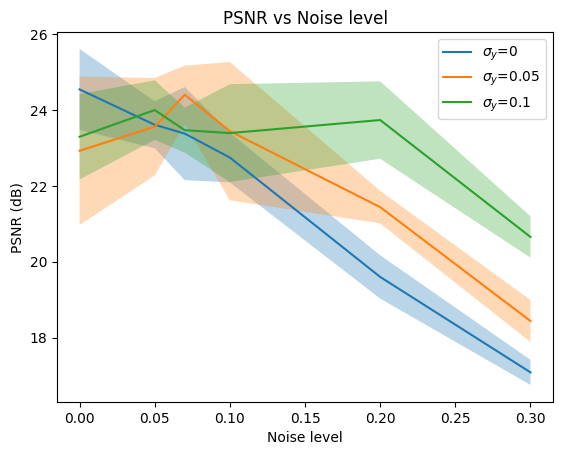

In [24]:
for i in range(len(psnrs_all)):
    plt.plot(sigma_noises[:-2], psnrs_all[i][:-2], label=r'$\sigma_y$={}'.format(sigma_ys[i]))
    plt.fill_between(sigma_noises[:-2], psnrs_all[i][:-2]-stds[i][:-2], psnrs_all[i][:-2]+stds[i][:-2], alpha=0.3)
plt.xlabel('Noise level')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.title('PSNR vs Noise level')
plt.show()
